In [6]:
!pip install arch




  Obtaining dependency information for arch from https://files.pythonhosted.org/packages/d6/47/11330b7cd468d1b2e18fbc6e2f7ae9238febe3f93ac393791f47fe98c021/arch-7.0.0-cp39-cp39-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for numpy>=1.22.3 from https://files.pythonhosted.org/packages/79/56/fb78389e7a1b1d0aa20dd0cbda5110d68f5df77b0a704180f0959b4f8ad1/numpy-2.0.0-cp39-cp39-macosx_10_9_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 976.8 kB/s eta 0:00:00 0:00:01
  Obtaining dependency information for numpy>=1.22.3 from https://files.pythonhosted.org/packages/7d/24/ce71dc08f06534269f66e73c04f5709ee024a1afe92a7b6e1d73f158e1f8/numpy-1.26.4-cp39-cp39-macosx_10_9_x86_64.whl.metadata
  Using cached numpy-1.26.4-cp39-cp39-macosx_10_9_x86_64.whl.metadata (61 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 956.8/956.8 kB 4.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 5.5 MB/s eta 0:00:0000:0100:01
  Attemp

In [7]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL
from arch import arch_model
import seaborn as sns

In [27]:
#Load data
AAPL = pd.read_csv('AAPL.csv')

AAPL.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [28]:
# Preprocess data
AAPL['Date'] = pd.to_datetime(AAPL['Date'], format='%Y-%m-%d')
AAPL = AAPL.set_index('Date')
AAPL = AAPL.sort_index()

AAPL.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099722,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094519,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087582,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089749,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092351,73449600


In [31]:
# Check for zero or negative values in 'Close' column
print((AAPL['Close'] <= 0).sum())




0


In [33]:

# Replace zero or negative values with a small positive number (e.g., 1e-3)
AAPL['Close'] = AAPL['Close'].apply(lambda x: x if x > 0 else 1e-3)

AAPL['Close']

Date
1980-12-12      0.128348
1980-12-15      0.121652
1980-12-16      0.112723
1980-12-17      0.115513
1980-12-18      0.118862
                 ...    
2023-05-04    165.789993
2023-05-05    173.570007
2023-05-08    173.500000
2023-05-09    171.770004
2023-05-10    173.559998
Name: Close, Length: 10692, dtype: float64

In [36]:
# Reverse the DataFrame
rev_data_frame = AAPL.iloc[::-1]
rev_data_frame


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-10,173.020004,174.029999,171.899994,173.559998,173.559998,53724500
2023-05-09,173.050003,173.539993,171.600006,171.770004,171.770004,45326900
2023-05-08,172.479996,173.850006,172.110001,173.500000,173.500000,55962800
2023-05-05,170.979996,174.300003,170.759995,173.570007,173.570007,113316400
2023-05-04,164.889999,167.039993,164.309998,165.789993,165.789993,81235400
...,...,...,...,...,...,...
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092351,73449600
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089749,86441600
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087582,105728000


In [38]:
# Convert to time series
AAPLts = rev_data_frame['Close']
AAPLts.index = pd.date_range(start='2007-01-01', periods=len(AAPLts), freq='B')
AAPLts.index 

DatetimeIndex(['2007-01-01', '2007-01-02', '2007-01-03', '2007-01-04',
               '2007-01-05', '2007-01-08', '2007-01-09', '2007-01-10',
               '2007-01-11', '2007-01-12',
               ...
               '2047-12-11', '2047-12-12', '2047-12-13', '2047-12-16',
               '2047-12-17', '2047-12-18', '2047-12-19', '2047-12-20',
               '2047-12-23', '2047-12-24'],
              dtype='datetime64[ns]', length=10692, freq='B')

<Figure size 2880x720 with 0 Axes>

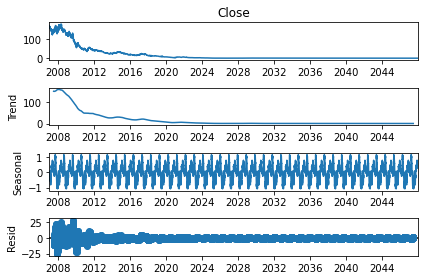

In [49]:

# Plot decomposed series with an additive model
result = seasonal_decompose(AAPLts, model='additive', period=252)

plt.figure(figsize=(40, 10))  # Set your desired width and height

# Plot decomposed series with an additive model
result.plot()
plt.show()

/Users/yuntzuyu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


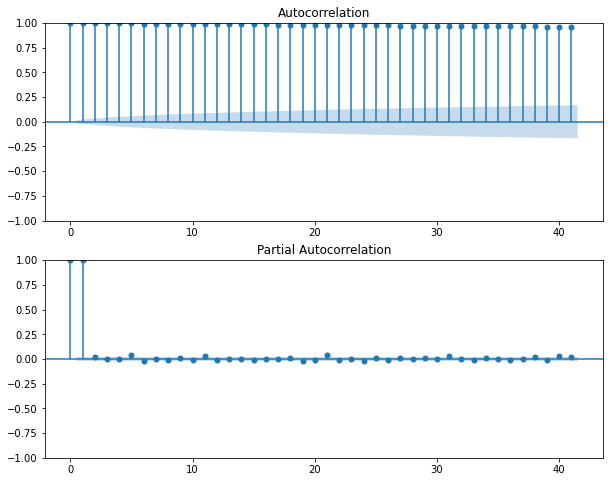

In [50]:
# Auto-correlation plot
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(AAPLts, ax=ax[0])
plot_pacf(AAPLts, ax=ax[1])
plt.show()



In [51]:
# Perform ADF test
adf_result = adfuller(AAPLts)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')



ADF Statistic: -4.596926086291739
p-value: 0.00013086529659913813


In [52]:
# Perform KPSS test
kpss_result = kpss(AAPLts, regression='c')
print(f'KPSS Statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')



KPSS Statistic: 8.274130483685925
p-value: 0.01


/Users/yuntzuyu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [55]:
# Log transformation
AAPLtslog = np.log(AAPLts)
AAPLtslog.head()


2007-01-01    5.156523
2007-01-02    5.146156
2007-01-03    5.156178
2007-01-04    5.156581
2007-01-05    5.110722
Freq: B, Name: Close, dtype: float64

In [57]:
# Differencing
AAPLtslogdiff = AAPLtslog.diff().dropna()
AAPLtslogdiff.head()


2007-01-02   -0.010367
2007-01-03    0.010021
2007-01-04    0.000403
2007-01-05   -0.045859
2007-01-08    0.009963
Freq: B, Name: Close, dtype: float64

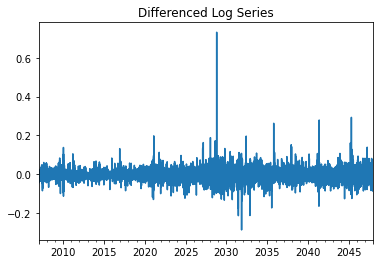

In [58]:
# Plot differenced series
AAPLtslogdiff.plot(title='Differenced Log Series')
plt.show()



In [59]:
# ARIMA Model
model = ARIMA(AAPLtslog, order=(0, 1, 4))
fitAAPL1 = model.fit()
print(fitAAPL1.summary())



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                10692
Model:                 ARIMA(0, 1, 4)   Log Likelihood               22829.535
Date:                Mon, 01 Jul 2024   AIC                         -45649.071
Time:                        12:03:22   BIC                         -45612.685
Sample:                    01-01-2007   HQIC                        -45636.795
                         - 12-24-2047                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0165      0.006      2.706      0.007       0.005       0.029
ma.L2         -0.0192      0.006     -3.108      0.002      -0.031      -0.007
ma.L3         -0.0296      0.007     -4.497      0.0

/Users/yuntzuyu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


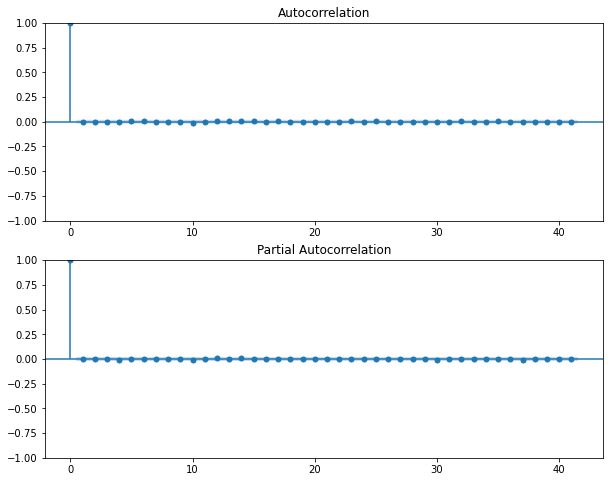

In [60]:
# Residual analysis
residuals = fitAAPL1.resid
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(residuals, ax=ax[0])
plot_pacf(residuals, ax=ax[1])
plt.show()


In [61]:

# Forecasting
forecast = fitAAPL1.get_forecast(steps=100)
forecast_ci = forecast.conf_int()



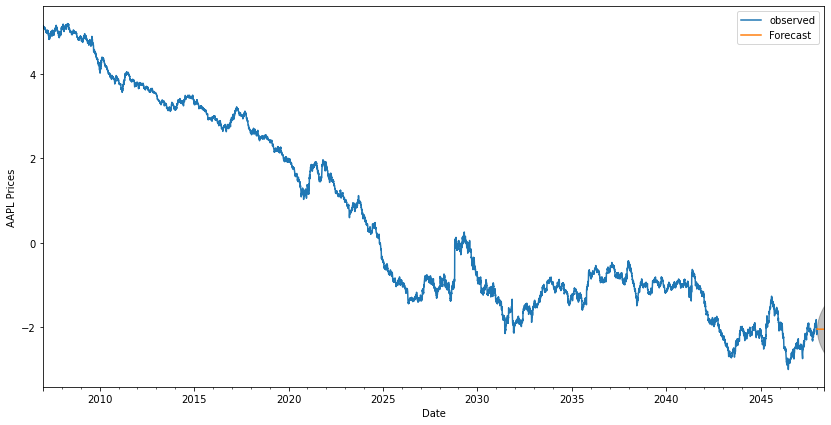

In [62]:
# Plot forecast
ax = AAPLtslog.plot(label='observed', figsize=(14, 7))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('AAPL Prices')
plt.legend()
plt.show()



In [63]:
# GARCH model
am = arch_model(residuals, vol='Garch', p=1, q=1)
garch_fit = am.fit()
print(garch_fit.summary())



Iteration:      1,   Func. Count:      6,   Neg. LLF: 6064461107.6094675
Iteration:      2,   Func. Count:     21,   Neg. LLF: 115462420848.8406
Iteration:      3,   Func. Count:     36,   Neg. LLF: 30945.095725344676
Iteration:      4,   Func. Count:     41,   Neg. LLF: 38177.263188975645
Iteration:      5,   Func. Count:     47,   Neg. LLF: 28399.87768860344
Iteration:      6,   Func. Count:     54,   Neg. LLF: 17767.219751606084
Iteration:      7,   Func. Count:     61,   Neg. LLF: 198500652.56776512
Iteration:      8,   Func. Count:     73,   Neg. LLF: -9125.652961412787
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9125.653042745325
            Iterations: 12
            Function evaluations: 73
            Gradient evaluations: 8
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squa

/Users/yuntzuyu/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003305. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


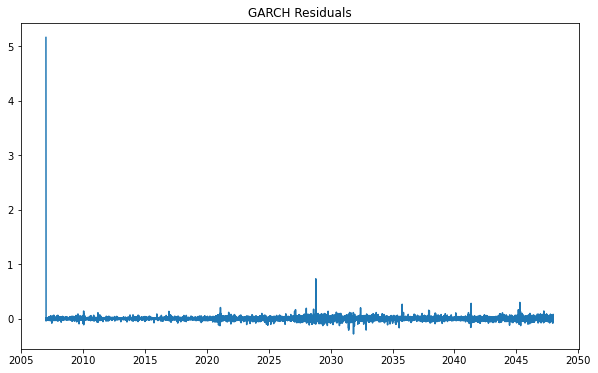

In [64]:
# Plot GARCH residuals
plt.figure(figsize=(10, 6))
plt.plot(garch_fit.resid)
plt.title('GARCH Residuals')
plt.show()
